# Air Quality in India

In [2]:
!pip install -q --upgrade kagglehub
!pip install -q missingno
!pip install -q tabulate

In [287]:
# import libraries
import kagglehub
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tabulate
import os
import warnings
import plotly.express as px
import json
import scipy.stats as st
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import lightgbm as lgb
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score

In [4]:
#loading data using kaggle api
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12


## AQI forecasting

### AQI forecasting: ARIMA

### AQI forecasting: LightGBM

We begin with **LightGBM** to quickly obtain highly accurate predictions and interpretable results. This model will serve as a reliable benchmark (baseline) for subsequent comparison with more complex deep learning architectures (LSTM) and statistical methods.

Methodology: Regime-Shift Robustness
- **Training (2015 - 2019):** We trained on stable, pre-pandemic data to learn the fundamental physics of seasonal and diurnal emission cycles.
- **Validation (Jan - Jun 2020):** We specifically validated on the COVID-19 lockdown era. This served as a stress test to ensure the model could adapt to the structural break caused by sudden drops in human activity.
- **Forecasting (Jul - Dec 2020):** The final prediction combines the historical seasonal inertia (winter smog expectations) with the specific context of the "new normal."

In [86]:
station_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589083 entries, 0 to 2589082
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Datetime          datetime64[ns]
 1   StationId         object        
 2   PM2.5             float64       
 3   PM10              float64       
 4   NO                float64       
 5   NO2               float64       
 6   NOx               float64       
 7   NH3               float64       
 8   CO                float64       
 9   SO2               float64       
 10  O3                float64       
 11  Benzene           float64       
 12  Toluene           float64       
 13  Date              object        
 14  Time              int32         
 15  Month             int32         
 16  Weekday           int32         
 17  Time_Period       category      
 18  StationName       object        
 19  City              object        
 20  State             object        
 21  Status  

In [87]:
# Creating separate dataset for the prediction
df = station_hour.sort_values(['StationId', 'Datetime']).copy()

# Creating additioal time variable alongside with time, month, day of week
df['dayofyear'] = df['Datetime'].dt.dayofyear

# Cyclical encoding
# Now 23:00 will be close to 00:00 mathematically
df['hour_sin'] = np.sin(2 * np.pi * df['Time'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Time'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [88]:
# Primary lag - 24 hours (one day ago)
df['lag_24'] = df.groupby('StationId')['AQI_final'].shift(24)

# Weekly lag - 168 hours (one week ago)
df['lag_168'] = df.groupby('StationId')['AQI_final'].shift(168)

# Rolling mean over 24 hours (trend)
# Note: We shift by 24 first to ensure we don't use future data
df['rolling_mean_24'] = df.groupby('StationId')['AQI_final'].transform(
    lambda x: x.shift(24).rolling(window=24).mean()
)

# The first 7 days of each station become NaN due to shift(168). We remove them.
df = df.dropna()

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2568953 entries, 183 to 2589082
Data columns (total 33 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Datetime          datetime64[ns]
 1   StationId         object        
 2   PM2.5             float64       
 3   PM10              float64       
 4   NO                float64       
 5   NO2               float64       
 6   NOx               float64       
 7   NH3               float64       
 8   CO                float64       
 9   SO2               float64       
 10  O3                float64       
 11  Benzene           float64       
 12  Toluene           float64       
 13  Date              object        
 14  Time              int32         
 15  Month             int32         
 16  Weekday           int32         
 17  Time_Period       category      
 18  StationName       object        
 19  City              object        
 20  State             object        
 21  Status     

In [90]:
#  Prepare StationId (LightGBM prefers 'category' type)
# If StationId is object/string (AP001, DL005...), convert to category
if df['StationId'].dtype == 'object':
    df['StationId'] = df['StationId'].astype('category')

In [91]:
# Define split boundaries
split_date_train = '2020-01-01'  # End of training period
split_date_test = '2020-07-01'   # End of available data (validation period)

In [92]:
# Data Slicing
# Train: Everything BEFORE 2020
train = df[df['Datetime'] < split_date_train].copy()

# Validation: First half of 2020 (COVID period)
val = df[(df['Datetime'] >= split_date_train) & (df['Datetime'] < split_date_test)].copy()

In [93]:
# Separate Features (X) and Target (y)
# Drop columns that are not features for the model
# (We remove City and State because StationId already captures this geo-information)
features_to_drop = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI_final', 'Datetime', 'AQI_bucket_final', 'City', 'Date', 'StationName', 'State', 'Status']

X_train = train.drop(columns=features_to_drop, errors='ignore')
y_train = train['AQI_final']

X_val = val.drop(columns=features_to_drop, errors='ignore')
y_val = val['AQI_final']

In [94]:
# Check shapes
print(f"--- Dataset Sizes ---")
print(f"Train (2015-2019): {X_train.shape} rows")
print(f"Validation (Jan-Jun 2020): {X_val.shape} rows")
print(f'Validation train ratio: {round(X_val.shape[0] / X_train.shape[0]*100, 2)}%')

# Verify feature columns
print(f"\nTraining Features: {X_train.columns.tolist()}")

--- Dataset Sizes ---
Train (2015-2019): (2108354, 14) rows
Validation (Jan-Jun 2020): (460491, 14) rows
Validation train ratio: 21.84%

Training Features: ['StationId', 'Time', 'Month', 'Weekday', 'Time_Period', 'Year', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_24', 'lag_168', 'rolling_mean_24']


In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2108354 entries, 183 to 2584713
Data columns (total 14 columns):
 #   Column           Dtype   
---  ------           -----   
 0   StationId        category
 1   Time             int32   
 2   Month            int32   
 3   Weekday          int32   
 4   Time_Period      category
 5   Year             int32   
 6   dayofyear        int32   
 7   hour_sin         float64 
 8   hour_cos         float64 
 9   month_sin        float64 
 10  month_cos        float64 
 11  lag_24           float64 
 12  lag_168          float64 
 13  rolling_mean_24  float64 
dtypes: category(2), float64(7), int32(5)
memory usage: 172.9 MB


In [96]:
# Creating Model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

**!Caution this step might be training for 2-3 hours!**

In [97]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 2108354, number of used features: 14
[LightGBM] [Info] Start training from score 190.386445
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 67.1646	valid_1's rmse: 51.2463
Early stopping, best iteration is:
[74]	training's rmse: 68.7984	valid_1's rmse: 49.8636


LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=1000, n_jobs=-1,
              objective='regression', random_state=42)

In [98]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

def print_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {set_name} ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R2:   {r2:.2f}")

print_metrics(y_train, y_pred_train, "TRAIN (2015-2019)")
print("\n")
print_metrics(y_val, y_pred_val, "VALIDATION (Jan-Jun 2020)")

--- TRAIN (2015-2019) ---
RMSE: 68.80
MAE:  36.89
R2:   0.77


--- VALIDATION (Jan-Jun 2020) ---
RMSE: 49.86
MAE:  31.51
R2:   0.72


In [99]:
residuals = y_val - y_pred_val

Text(0.5, 1.0, 'Residual analysis model 1')

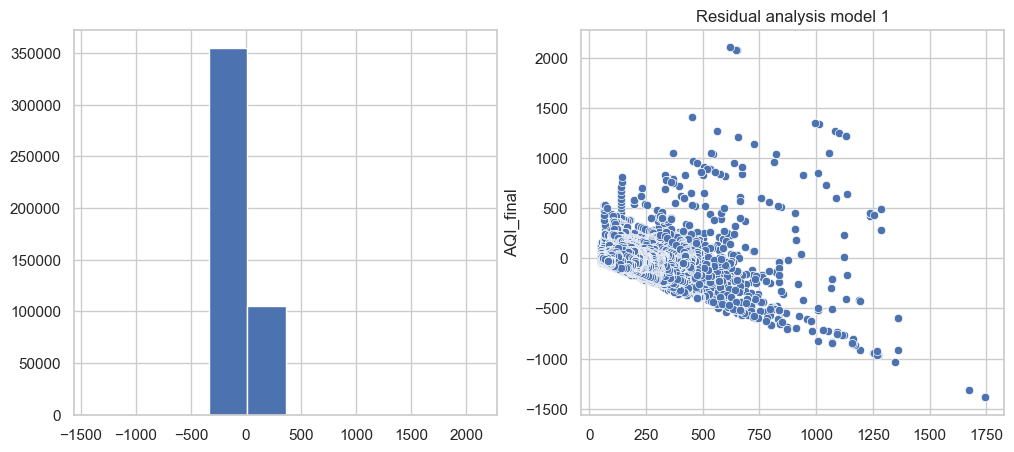

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(residuals)

sns.scatterplot(x=y_pred_val, y=residuals, ax=axes[1])
plt.title('Residual analysis model 1')

**Residual Analysis**
1. *Distribution of Residuals (Histogram):* The residual distribution is well-centered around zero. This indicates that the LightGBM model is unbiased on average. In general the destribution slightly right-skewed, meanig that model slightly overestimates the values, but in general model is quite precise.

2. *Residuals vs. Predicted Values (Scatter Plot):* The scatter plot reveals that the residuals are not perfectly random (homoscedastic). Instead, we observe distinct heteroscedasticity.

Low to Medium AQI: For lower predicted values, the residuals are tightly clustered around zero, indicating high precision.

High AQI: As the predicted AQI values increase, the variance of the residuals expands (a "funnel" shape).

**Conclusion:** While the model is robust for the majority of observations, the increasing error variance at high AQI levels suggests that extreme pollution events are inherently more volatile and harder to predict with high precision. However, the absence of clear non-linear patterns suggests the model has successfully captured the main relationships in the data.

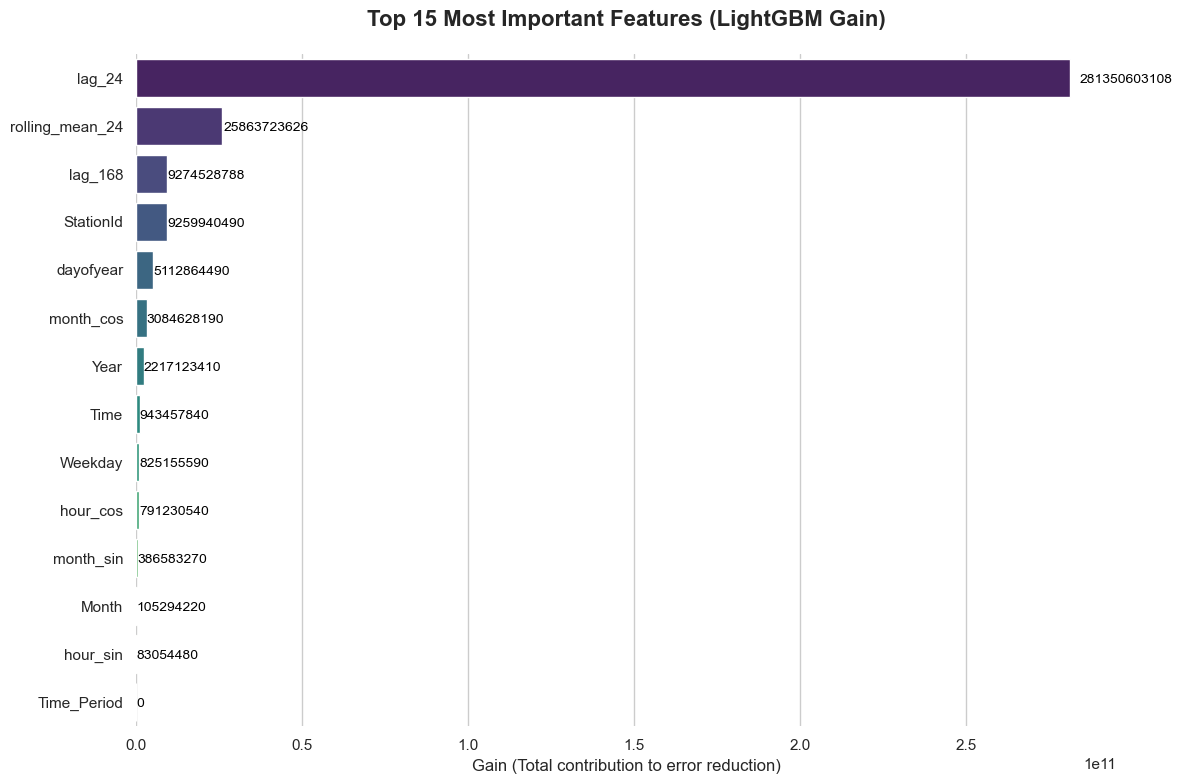

In [101]:
def plot_importance(model, X_train, num_features=15):
    
    importance_values = model.booster_.feature_importance(importance_type='gain')
    feature_names = X_train.columns
    
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Gain': importance_values
    })
    
    imp_df = imp_df.sort_values(by='Gain', ascending=False).head(num_features)
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid") # Чистый фон с сеткой
    
    ax = sns.barplot(x='Gain', y='Feature', data=imp_df, palette='viridis')
    
    plt.title(f'Top {num_features} Most Important Features (LightGBM Gain)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Gain (Total contribution to error reduction)', fontsize=12)
    plt.ylabel('') # Убираем подпись оси Y, названия признаков и так понятны
    
    sns.despine(left=True, bottom=True)
    
    for i, v in enumerate(imp_df['Gain']):
        ax.text(v + (v * 0.01), i + 0.1, f'{v:.0f}', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_importance(model, X_train, num_features=15)

**Features Importance Analysis**

The values on the graph (gain) represents to which extent this feature in the model reduces the error term for prediction.

The main feature in the predicting model is the AQI values lagged for 24 hours, this feature mainly reduces the error term for the predicting model. Also mean value for 24 hour and lagged values for 1 week (168 days) apper to be quite importat for the prediction. Less contribute time vriables such month, day, time, year.

We use **Recursive Forecasting Strategy** (Dynamic Simulation)

Since the standard batch prediction (e.g., `model.predict(X_test)`) is impossible for long-term forecasting because our model relies on **Lag Features**. For a date in December 2020, the "value from 24 hours ago" is unknown - it hasn't happened yet.

Therefore we implement an **Iterative Feedback Loop**:
1.  **Step:** Generate features for the current specific hour ($t$).
2.  **Predict:** Use the model to estimate AQI for $t$.
3.  **Update:** Write this prediction back into the dataset. It effectively becomes the "history" used to generate lags for future steps ($t+1, t+2...$).

In [102]:
# Define the date range for the forecast (July - Dec 2020)
future_dates = pd.date_range(start='2020-07-01 00:00:00', end='2020-12-31 23:00:00', freq='h')

In [103]:
# Create a Cartesian product of "All Stations" x "All Future Dates"
# We need a row for every station for every hour
stations = df['StationId'].unique()  # Get stations from the original dataset
future_df = pd.DataFrame([
    {'StationId': s, 'Datetime': d} 
    for s in stations 
    for d in future_dates
])

In [104]:
# Set correct data types
future_df['StationId'] = future_df['StationId'].astype('category')
future_df['AQI'] = np.nan  # Initialize target column with NaNs (to be filled by model)

In [105]:
future_df.describe()

,Datetime,AQI
count,485760,0.0
mean,2020-09-30 23:29:59.999999744,NaN
min,2020-07-01 00:00:00,NaN
25%,2020-08-15 23:45:00,NaN
50%,2020-09-30 23:30:00,NaN
75%,2020-11-15 23:15:00,NaN
max,2020-12-31 23:00:00,NaN
std,NaN,NaN


In [106]:
# Append "History Tail" (Last week of June)
# We need this data to calculate lags (e.g., lag_24) for the first few days of July.
# We take the last 168 hours (1 week) from the validation/original set.
history_tail = df[df['Datetime'] >= '2020-06-23'].copy()

# Keep only necessary columns to match the future structure
required_cols = ['StationId', 'Datetime', 'AQI_final']
history_tail = history_tail[required_cols]

In [107]:
# Merge History and Future into one simulation dataframe
# We will read from the past rows and write to the future rows in the loop.
full_simulation = pd.concat([history_tail, future_df], ignore_index=True)
full_simulation = full_simulation.sort_values(['StationId', 'Datetime']).reset_index(drop=True)

In [108]:
full_simulation.head()

,StationId,Datetime,AQI_final,AQI
0,AP001,2020-06-23 00:00:00,55.0,NaN
1,AP001,2020-06-23 01:00:00,55.0,NaN
2,AP001,2020-06-23 02:00:00,55.0,NaN
3,AP001,2020-06-23 03:00:00,55.0,NaN
4,AP001,2020-06-23 04:00:00,55.0,NaN


In [109]:
feature_cols = X_train.columns.tolist()

print(f"Starting simulation using {len(feature_cols)} features...")
full_simulation = full_simulation.drop_duplicates(subset=['StationId', 'Datetime'])

Starting simulation using 14 features...


In [110]:
station_dtype = full_simulation['StationId'].dtype
period_categories = ['Night', 'Morning', 'Day', 'Evening']
period_dtype = pd.CategoricalDtype(categories=period_categories, ordered=True)

for current_time in tqdm(future_dates):
    
    current_mask = (full_simulation['Datetime'] == current_time)
    
    if not current_mask.any():
        continue

    pred_batch = full_simulation.loc[current_mask, ['StationId']].copy()
    
    pred_batch['Month'] = current_time.month
    pred_batch['Weekday'] = current_time.weekday()
    pred_batch['Time'] = current_time.hour
    pred_batch['Year'] = current_time.year
    pred_batch['dayofyear'] = current_time.dayofyear

    # Time Period
    h = current_time.hour
    if 6 <= h < 12:
        period = 'Morning'
    elif 12 <= h < 18:
        period = 'Day'
    elif 18 <= h < 24:
        period = 'Evening'
    else:
        period = 'Night'
    
    pred_batch['Time_Period'] = period
    pred_batch['Time_Period'] = pred_batch['Time_Period'].astype(period_dtype)

    pred_batch['StationId'] = pred_batch['StationId'].astype(station_dtype)

    # Sin/Cos
    pred_batch['hour_sin'] = np.sin(2 * np.pi * h / 24)
    pred_batch['hour_cos'] = np.cos(2 * np.pi * h / 24)
    pred_batch['month_sin'] = np.sin(2 * np.pi * current_time.month / 12)
    pred_batch['month_cos'] = np.cos(2 * np.pi * current_time.month / 12)

    # Lag 24
    time_24_ago = current_time - pd.Timedelta(hours=24)
    aqi_24 = full_simulation.loc[full_simulation['Datetime'] == time_24_ago, ['StationId', 'AQI']]
    
    pred_batch = pred_batch.merge(aqi_24, on='StationId', how='left', suffixes=('', '_prev'))
    pred_batch = pred_batch.rename(columns={'AQI': 'lag_24'})
    
    # Lag 168
    time_168_ago = current_time - pd.Timedelta(hours=168)
    aqi_168 = full_simulation.loc[full_simulation['Datetime'] == time_168_ago, ['StationId', 'AQI']]
    
    pred_batch = pred_batch.merge(aqi_168, on='StationId', how='left')
    pred_batch = pred_batch.rename(columns={'AQI': 'lag_168'})

    pred_batch['lag_24'] = pred_batch['lag_24'].ffill().fillna(0)
    pred_batch['lag_168'] = pred_batch['lag_168'].ffill().fillna(0)

    pred_batch['rolling_mean_24'] = pred_batch['lag_24']
    
    X_test_step = pred_batch[feature_cols]
    
    # Теперь ошибки быть не должно, так как категории совпадают
    current_preds = model.predict(X_test_step)
    
    full_simulation.loc[current_mask, 'AQI'] = current_preds

100%|██████████████████████████████████████████████████████████████████████████████| 4416/4416 [03:46<00:00, 19.52it/s]


In [111]:
full_simulation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506496 entries, 0 to 506603
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   StationId  506496 non-null  category      
 1   Datetime   506496 non-null  datetime64[ns]
 2   AQI_final  20844 non-null   float64       
 3   AQI        485760 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 15.9 MB


In [112]:
full_simulation

,StationId,Datetime,AQI_final,AQI
0,AP001,2020-06-23 00:00:00,55.0,NaN
1,AP001,2020-06-23 01:00:00,55.0,NaN
2,AP001,2020-06-23 02:00:00,55.0,NaN
3,AP001,2020-06-23 03:00:00,55.0,NaN
4,AP001,2020-06-23 04:00:00,55.0,NaN
...,...,...,...,...
506599,WB013,2020-12-31 19:00:00,NaN,213.467152
506600,WB013,2020-12-31 20:00:00,NaN,213.467152
506601,WB013,2020-12-31 21:00:00,NaN,213.467152
506602,WB013,2020-12-31 22:00:00,NaN,213.467152


In [113]:
history_data = df[df['Datetime'] < '2020-07-01'].copy()

forecast_data_lgbm = full_simulation.loc[
    full_simulation['Datetime'] >= '2020-07-01', 
    ['Datetime', 'AQI']
].copy()

hist_monthly = history_data.set_index('Datetime')['AQI_final'].resample('MS').mean()
fc_monthly = forecast_data_lgbm.set_index('Datetime')['AQI'].resample('MS').mean()

last_hist_point = hist_monthly.iloc[[-1]]

fc_monthly_connected = pd.concat([last_hist_point, fc_monthly])

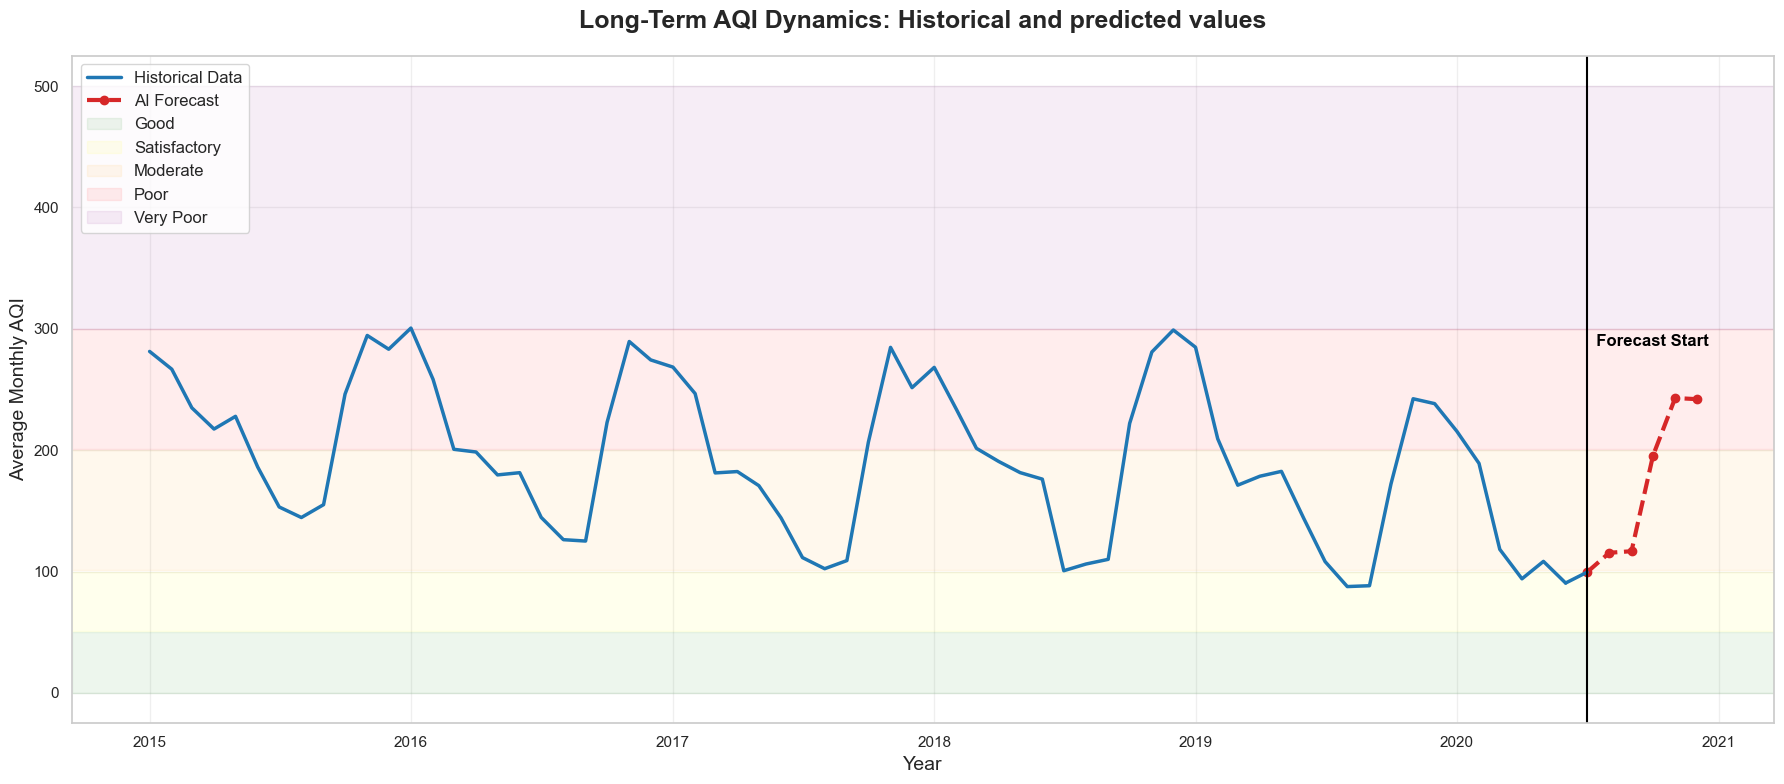

In [114]:
plt.figure(figsize=(18, 8))
sns.set_style("whitegrid")

# Historical data (blue line)
plt.plot(hist_monthly.index, hist_monthly.values, 
         label='Historical Data', color='#1f77b4', linewidth=2.5)

# Forecasted values (red line)
plt.plot(fc_monthly.index, fc_monthly.values, 
         label='AI Forecast', color='#d62728', linewidth=3, linestyle='--', marker='o')

# Connecting historical and predicted data
plt.plot([hist_monthly.index[-1], fc_monthly.index[0]], 
         [hist_monthly.values[-1], fc_monthly.values[0]], 
         color='#1f77b4', linestyle='-', linewidth=2.5)

# Verticel line (start of the forecast)
plt.axvline(pd.to_datetime('2020-07-01'), color='black', linestyle='-', linewidth=1.5)
plt.text(pd.to_datetime('2020-07-01'), plt.ylim()[1]*0.95, '  Forecast Start', 
         color='black', fontweight='bold', ha='left', va='top')

# Coluoring zones based on Air Quality 
full_index = pd.concat([hist_monthly, fc_monthly]).index
plt.axhspan(0, 50, color='green', alpha=0.07, label='Good')
plt.axhspan(51, 100, color='yellow', alpha=0.07, label='Satisfactory')
plt.axhspan(101, 200, color='orange', alpha=0.07, label='Moderate')
plt.axhspan(201, 300, color='red', alpha=0.07, label='Poor')
plt.axhspan(300, 500, color='purple', alpha=0.07, label='Very Poor')

plt.title('Long-Term AQI Dynamics: Historical and predicted values', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Average Monthly AQI', fontsize=14)
plt.xlabel('Year', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', frameon=True, fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Conclusion: LightGBM Forecasting Model**
- **Feature Engineering & Data Leakage Prevention:** We developed a LightGBM regressor using strictly temporal features (hour, month, seasonality via cyclical sin/cos transformations) and historical lags. We intentionally excluded concurrent pollutant measurements (e.g., current PM2.5, CO) to prevent data leakage, ensuring the model simulates a realistic forecasting scenario where future chemical compositions are unknown.
- **Recursive Forecasting Strategy:**
To predict AQI for the extended horizon (July–December 2020), we implemented a Recursive Multi-Step Strategy. This approach is essential for capturing the high inertia of air quality data: the model predicts one hour ahead ($t+1$), and this prediction is fed back into the dataset as a lag feature to generate the subsequent prediction ($t+2$), preserving the continuity of the time series
- **Adaptability to COVID-19 Anomalies:** Despite being trained on "normal" pre-pandemic conditions (2015–2019), the model showed remarkable robustness during the COVID-19 lockdown validation period (Jan–June 2020). This adaptability is driven by strong autocorrelation captured by lag features (specifically lag_24). These features act as a self-correcting mechanism, allowing the model to quickly adjust to the structural shift of lower pollution levels based on the immediate history, without requiring specific "lockdown" flags..

### AQI forecasting: RNN LTSM (Long Short-Term Memory)